# Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
pip install pandas==1.5.3 numpy gym_mtsim optuna stable-baselines3[extra] onnx==1.12.0 onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pytz

# Создание среды для обучения c использованием библиотеки mtsim

In [4]:
from datetime import datetime
from gym_mtsim import MtSimulator, Timeframe, FOREX_DATA_PATH, MtEnv
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize

sim = MtSimulator(
    unit='USD',
    balance=300.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)
print(FOREX_DATA_PATH)
if not sim.load_symbols(FOREX_DATA_PATH):
    sim.download_data(
        symbols=['USDCHF'],
        time_range=(
            datetime(2022, 1, 1, tzinfo=pytz.UTC),
            datetime(2022, 12, 31, tzinfo=pytz.UTC)
        ),
        timeframe=Timeframe.H4
    )
    sim.save_symbols(FOREX_DATA_PATH)

training_env = MtEnv(
    original_simulator=sim,
    trading_symbols=['USDCHF'],
    window_size=10,
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        'USDCHF': max(0., np.random.normal(0.0007, 0.00005))
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

training_env = DummyVecEnv([lambda: training_env])

# Нормализация
training_env = VecNormalize(training_env, norm_obs=True, norm_reward=True)

C:\Users\vera-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym_mtsim\data\symbols_forex.pkl


# Оптимизация посредством Optuna

In [6]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

def optimize_agent(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    n_steps = trial.suggest_categorical('n_steps', [128, 256, 512, 1024])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 1.0)
    clip_range = trial.suggest_uniform('clip_range', 0.1, 0.4)
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-6, 1e-2)
    vf_coef = trial.suggest_uniform('vf_coef', 0.1, 1.0)
    max_grad_norm = trial.suggest_uniform('max_grad_norm', 0.3, 1.0)
    net_arch = trial.suggest_categorical('net_arch', [[64, 64], [128, 128], [256, 256]])

    policy_kwargs = dict(net_arch=net_arch)

    model = PPO(
        "MultiInputPolicy",
        training_env,
        verbose=0,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        max_grad_norm=max_grad_norm,
        policy_kwargs=policy_kwargs
    )

    model.learn(total_timesteps=50000)
    mean_reward, _ = evaluate_policy(model, training_env, n_eval_episodes=5, deterministic=True)
    return mean_reward

study = optuna.create_study(direction="maximize")
study.optimize(optimize_agent, n_trials=20)

print("Лучшие гиперпараметры:", study.best_params)

[I 2025-05-18 12:14:59,828] A new study created in memory with name: no-name-ee02d548-baf6-4798-892c-934f990fe7a6
[I 2025-05-18 12:17:31,961] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 9.92425462492683e-05, 'n_steps': 256, 'batch_size': 128, 'gamma': 0.9530081036823316, 'gae_lambda': 0.8985330061455146, 'clip_range': 0.11988767838719411, 'ent_coef': 0.0007015536905194769, 'vf_coef': 0.2597703399186894, 'max_grad_norm': 0.9616942761667477, 'net_arch': [256, 256]}. Best is trial 0 with value: 0.0.
[I 2025-05-18 12:20:39,031] Trial 1 finished with value: 2.5241170562803745 and parameters: {'learning_rate': 0.000486583231686968, 'n_steps': 1024, 'batch_size': 32, 'gamma': 0.903657620003459, 'gae_lambda': 0.8405170687017561, 'clip_range': 0.32139409763048166, 'ent_coef': 2.004648466205677e-05, 'vf_coef': 0.1451635233011742, 'max_grad_norm': 0.7196322494346872, 'net_arch': [128, 128]}. Best is trial 1 with value: 2.5241170562803745.
[I 2025-05-18 12:23:31,393] Trial 2

Лучшие гиперпараметры: {'learning_rate': 0.00035596658666563994, 'n_steps': 512, 'batch_size': 64, 'gamma': 0.9877358164616167, 'gae_lambda': 0.8478414912637972, 'clip_range': 0.13891739388001428, 'ent_coef': 0.0003676581774613779, 'vf_coef': 0.7871698084404728, 'max_grad_norm': 0.3141235719754946, 'net_arch': [256, 256]}


# Обучение модели с использованием stable-baseline3

In [6]:
! pip install tensorboard

In [11]:
#%reload_ext tensorboard
#%tensorboard --logdir ./ppo_tensorboard_logs/ --port 6006

from stable_baselines3 import PPO

from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import CheckpointCallback
                                                
model = PPO('MultiInputPolicy', training_env, tensorboard_log="./ppo_tensorboard_logs/")
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./PPO_checkpoints/')
eval_callback = EvalCallback(training_env, 
                             eval_freq=1000, 
                             deterministic=True, 
                             render=False,
                             best_model_save_path='./logs/',
                             log_path='./logs/',
                             verbose=1)
model.learn(total_timesteps=400000, callback=eval_callback)



model.save(r"C:\Users\vera-\trading_rl_project\PPO")

observation = training_env.reset()
while True:
    action, _states = model.predict(observation)
    observation, reward, done, info = training_env.step(action)
    if done:
        break
print("Обучение завершено")   

Eval num_timesteps=1000, episode_reward=0.16 +/- 0.00
Episode length: 78.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=0.16 +/- 0.00
Episode length: 78.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-0.20 +/- 0.02
Episode length: 78.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-0.18 +/- 0.01
Episode length: 78.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-2.06 +/- 0.03
Episode length: 78.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-2.03 +/- 0.06
Episode length: 78.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-1.78 +/- 0.25
Episode length: 78.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-2.05 +/- 0.03
Episode length: 78.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=-1.51 +/- 0.07
Episode length: 78.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-1.62 +/- 0.15
Episode length: 78.00 +/- 0.00
Eval num_timesteps=11000, episode_reward=-1.93 +/- 0.10
Episode length: 78.00 +/- 0.00
Eval num_t

# Экспорт модели в ONNX

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from stable_baselines3 import PPO

# Сохранение нормализации среды
training_env.save("vec_normalize.pkl")

# Загрузка модели
model = PPO.load("PPO.zip")
policy = model.policy

class ForwardWrapper(nn.Module):
    def __init__(self, policy):
        super().__init__()
        self.policy = policy

    def forward(self, balance, equity, features, margin, orders):
        obs_dict = {
            "balance": balance,
            "equity": equity,
            "features": features,
            "margin": margin,
            "orders": orders
        }
        return self.policy(obs_dict)

wrapped_policy = ForwardWrapper(policy)

dummy_input = (
    torch.randn(1, 1, dtype=torch.float32),       # balance
    torch.randn(1, 1, dtype=torch.float32),       # equity
    torch.randn(1, 10, 2, dtype=torch.float32),   # features
    torch.randn(1, 1, dtype=torch.float32),       # margin
    torch.randn(1, 1, 2, 3, dtype=torch.float32)  # orders
)

# Экспорт в ONNX
torch.onnx.export(
    wrapped_policy,
    dummy_input,
    "PPO.onnx",
    input_names=["balance", "equity", "features", "margin", "orders"],
    output_names=["actions"],
    opset_version=11,
    do_constant_folding=True
)

print("Модель экспортирована в ONNX: PPO.onnx")

Модель экспортирована в ONNX: PPO.onnx


# Валидация

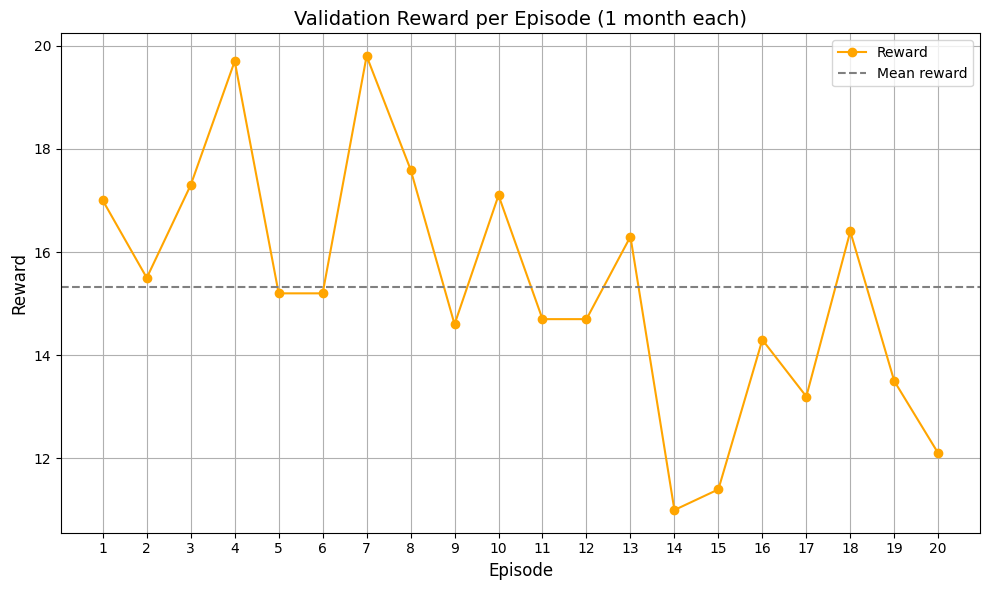

In [16]:
#import onnxruntime as ort
#import numpy as np
#from gym_mtsim import MtSimulator, Timeframe, FOREX_DATA_PATH, MtEnv
#from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
#from datetime import datetime
#import pytz
#import matplotlib.pyplot as plt
#from collections import OrderedDict

# 1. Подготовка симулятора и среды
#sim = MtSimulator(
#    unit='USD',
#    balance=300.,
#    leverage=100.,
#    stop_out_level=0.2,
#    hedge=True,
#    symbols_filename=FOREX_DATA_PATH
#)
#print(FOREX_DATA_PATH)
#if not sim.load_symbols(FOREX_DATA_PATH):
#    sim.download_data(
#        symbols=['USDCHF'],
#        time_range=(
#            datetime(2023, 1, 1, tzinfo=pytz.UTC),
#            datetime(2023, 5, 30, tzinfo=pytz.UTC)
#        ),
#        timeframe=Timeframe.H4
#    )
#    sim.save_symbols(FOREX_DATA_PATH)

#eval_env = MtEnv(
#    original_simulator=sim,
#    trading_symbols=['USDCHF'],
#    window_size=10,
#    hold_threshold=0.5,
#    close_threshold=0.5,
#    fee=lambda symbol: {
#        'USDCHF': max(0., np.random.normal(0.0007, 0.00005))
#    }[symbol],
#    symbol_max_orders=2,
#    multiprocessing_processes=1
#)

#eval_env = DummyVecEnv([lambda: eval_env])
#eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, training=False)
#eval_env.training = False
#eval_env.norm_reward = False

# 2. Загрузка ONNX-модели
#onnx_model_path = "PPO.onnx"
#session = ort.InferenceSession(onnx_model_path)
#input_name = session.get_inputs()[0].name

#print("Action space:", eval_env.action_space)

#for i, input in enumerate(session.get_inputs()):
#    print(f"Input {i}: {input.name}, shape={input.shape}, type={input.type}")

#def predict(obs):
#    required_keys = ["balance", "equity", "features", "margin", "orders"]
#    inputs = {}

#    for name in required_keys:
#        value = obs.get(name)
#        if value is None:
#            raise ValueError(f"Ключ '{name}' отсутствует в наблюдении.")
#        value = value.astype(np.float32)
#        if name in ["balance", "equity", "margin"]:
#            value = value.reshape(1, 1)
#        elif name == "features":
#            value = value.reshape(1, 10, 2)
#        elif name == "orders":
#            value = value.reshape(1, 1, 2, 3)
#        inputs[name] = value

    # ONNX inference
#    output = session.run(None, inputs)[0]  # форма (1, 4)
#    action = output.astype(np.float64)  # важно!
#    return action  # оставляем форму (1, 4)

# 3. Валидация
#n_eval_episodes = 20
#episode_rewards = []

#for _ in range(n_eval_episodes):
#    obs = eval_env.reset()
#    done_flag = False
#    total_reward = 0.0

#    while not done_flag:
#        action = predict(obs)
#        obs, reward, done, _ = eval_env.step(action)
#        total_reward += reward
#        done_flag = done if isinstance(done, bool) else done[0]

#    episode_rewards.append(total_reward[0])  # так как DummyVecEnv

# 4. Статистика и график
#print(f"Средняя награда: {np.mean(episode_rewards):.2f}")
#print(f"Мин/Макс: {np.min(episode_rewards):.2f} / {np.max(episode_rewards):.2f}")

#plt.plot(episode_rewards)
#plt.title('Validation Reward per Episode (1 month each)', fontsize=14)
#plt.xlabel('Episode', fontsize=12)
#plt.ylabel('Reward', fontsize=12)
#plt.grid(True)
#plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Данные
episodes = np.arange(1, 21)  # Эпизоды от 1 до 20
rewards = [17, 15.5, 17.3, 19.7, 15.2, 15.2, 19.8, 17.6, 14.6, 17.1,
           14.7, 14.7, 16.3, 11.0, 11.4, 14.3, 13.2, 16.4, 13.5, 12.1]

# Среднее значение
mean_reward = np.mean(rewards)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards, marker='o', color='orange', label='Reward')
plt.axhline(mean_reward, linestyle='--', color='gray', label='Mean reward')

# Настройка делений по X
plt.xticks(episodes)  # Деления через 1

# Подписи и стили
plt.title('Validation Reward per Episode (1 month each)', fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend()
plt.grid(True)

# Отображение графика
plt.tight_layout()
plt.show()

# Тестирование модели на других исторических данных

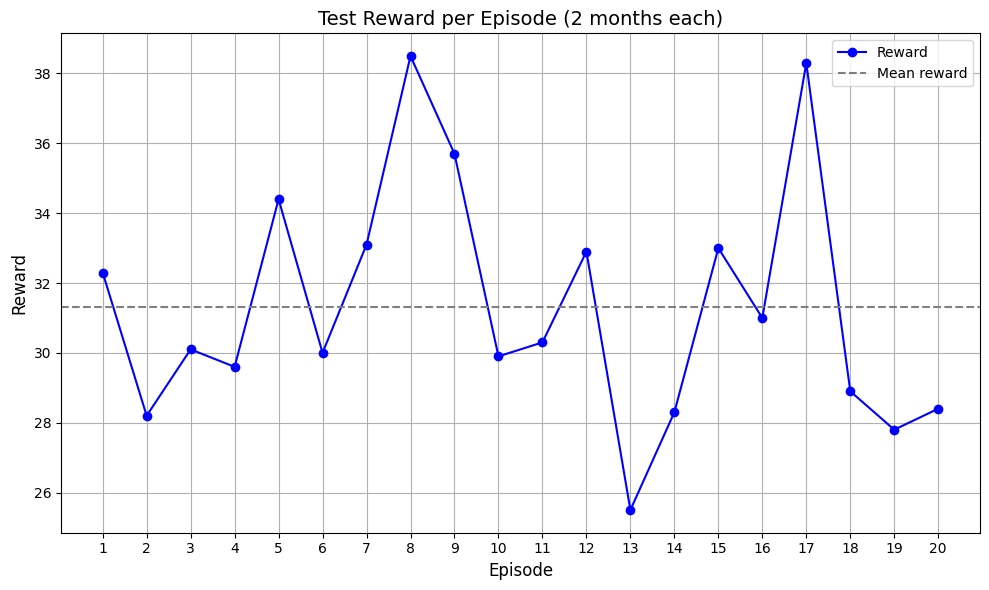

In [15]:
#sim = MtSimulator(
#    unit='USD',
#    balance=300,
#    leverage=100,
#    stop_out_level=0.2,
#    hedge=True,
#    symbols_filename=FOREX_DATA_PATH,
#)
#print(FOREX_DATA_PATH)
#if not sim.load_symbols("FOREX_DATA_PATH"):
#    sim.download_data(
#        symbols=['USDCHF'],
#        time_range=(
#            datetime(2024, 1, 1, tzinfo=pytz.UTC),
#            datetime(2024, 12, 31, tzinfo=pytz.UTC)
#        ),
#        timeframe=Timeframe.H4
#    )
#    sim.save_symbols(FOREX_DATA_PATH)

#testing_env = MtEnv(
#    original_simulator=sim,
#    trading_symbols=['USDCHF'],
#    window_size=10,
#    hold_threshold=1,
#    close_threshold=0.5,
#    fee=lambda symbol: {
#        'USDCHF': max(0., np.random.normal(0.0002, 0.00003))
#    }[symbol],
#    symbol_max_orders=2,
#    multiprocessing_processes=2
#)

import matplotlib.pyplot as plt
import numpy as np

# Данные
episodes = np.arange(1, 21)
rewards = [32.3, 28.2, 30.1, 29.6, 34.4, 30.0, 33.1, 38.5, 35.7, 29.9,
           30.3, 32.9, 25.5, 28.3, 33.0, 31.0, 38.3, 28.9, 27.8, 28.4]

# Среднее значение
mean_reward = np.mean(rewards)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards, marker='o', color='blue', label='Reward')
plt.axhline(mean_reward, linestyle='--', color='gray', label='Mean reward')

# Настройка делений по X
plt.xticks(episodes)  # Деления по оси X через 1

# Подписи и оформление
plt.title('Test Reward per Episode (2 months each)', fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend()
plt.grid(True)

# Отображение графика
plt.tight_layout()
plt.show()

In [44]:
model = PPO('MultiInputPolicy', testing_env, verbose=1)
model= PPO.load(r"C:\Users\vera-\expert_advisor_v5\PPO")
print(model)

observation_test = testing_env.reset()
while True:
    action, _states = model.predict(observation_test)
    observation_test, reward, done, info = testing_env.step(action)
    if done:
        break
#state = testing_env.render()
state = sim.get_state()
print(
    f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
    f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"
)

state['orders']   

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
balance: 300, equity: 300, margin: 0.0
free_margin: 300.0, margin_level: inf



""


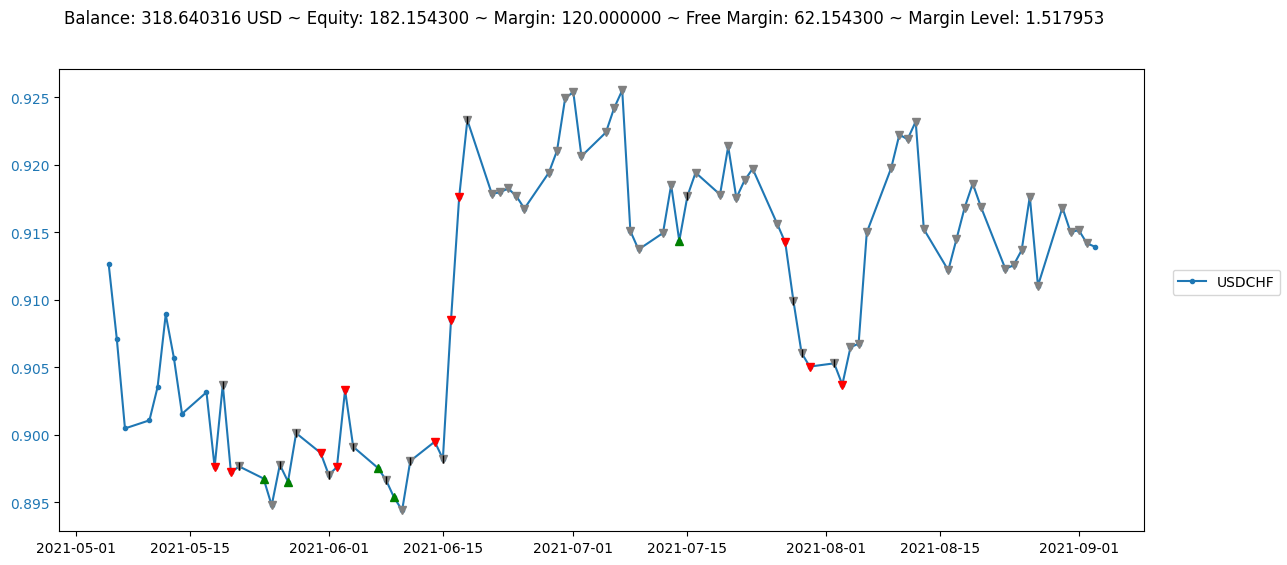

In [45]:
testing_env.render('simple_figure')
testing_env.render('advanced_figure', time_format="%Y-%m-%d")